In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.ticker import FuncFormatter
import seaborn as sns
from pathlib import Path
import yfinance as yf
import pandas_ta as ta
import mplfinance as mpf
import warnings
from utils.portfolio_metrics import calculate_portfolio_metrics
from utils.bond_math import *
warnings.filterwarnings('ignore')

# basic setup and read the data
cmap = cm.get_cmap('Pastel1')
PROJECT_DIR = Path().resolve()
data = pd.read_pickle(PROJECT_DIR / "processed_data/bonds-analyzed.pkl")

# in case, there is a problem...
copy = data.copy()

# Table of Contents
1. [Credit Risk and CDS Spreads](#1)
2. [Geopolitical Risks](#2)
3. [Liquidity and Bid-Ask Spreads](#3)
4. [A Closer Look at the U.S. Bonds...](#4)

    i. [US 2-years](#41)
   
    ii. [US 2-to-5-years](#42)
   
    iii. [US 5-to-10-years](#43)
   
    iv. [US >10-years](#44)
   
    v. [US <2-years](#45)

5. [European Bonds](#5)
6. [Emerging Market Bonds](#6)
7. [Model Portfolio](#7)
8. [Monte Carlo Simulations and Value-at-Risk](#8)
9. [Using Technical Analysis Tools for Shorter Term Trades](#9)
***

**Note:** Missing credit ratings in `BBG Composite` column are filled after the portfolio selection. If the rating of the issuer by the S\&P is available, it is used to fill NaN, if not, I simply added country rating to that bond.

***

### 1. Credit Risk and CDS Spreads <a class="anchor" id="1"></a>

Drop countries if the **probability of default is more than 10\%**. For that, assumptions:
+ Recovery rate to be 40\% and loss severity to be 60\%
+ Using 5-yr CDS spreads as the benchmark

In [2]:
# loss severity is assumed to be 60%
loss_severity = 0.6

# probability of default using 5-yr CDS spreads
data['PD_5y_pct'] = data['Spread_5y'] / loss_severity / 100

# drop rows if default probability is higher than 10%
# if "<= 10", it also drops NaNs, so simply choose "not (> 10)"
data = data[~(data['PD_5y_pct'] > 10)]

In [3]:
diff_cntry = set(copy['Country']) - set(data['Country'])
print(diff_cntry)

{'Tunisia', 'Argentina', 'Pakistan', 'El Salvador', 'Gabon', 'Ecuador', 'Egypt'}


### 2. Geopolitical Risks <a class="anchor" id="2"></a>
+ **Russia-Ukraine conflict** (+ **Belarus**, due to the sanctions)
+ **Israel-Hamas conflict** (+ **Lebanon**, due to the potential Hezbullah involvement)
+ **Azerbaijan-Armenia conflict**
+ **Argentina** and **Venezuela**, due to their idiosyncratic risks

In [4]:
data = data[~data['Country'].isin(['Lebanon', 'Armenia', 'Russia', 'Israel', 'Ukraine', 'Belarus', 'Venezuela'])]

### 3. Liquidity and Bid-Ask Spreads <a class="anchor" id="3"></a>

Before creating thresholds for the bid-ask spreads, I **drop CALLABLE and PUTABLE** since:
+ Anticipating interest rate cuts after 2024Q2
+ **“callable”:** cheaper re-financing for issuers → ***increasing reinvestment risk***
+ **“putable”:** declining rates → ***less value of put option***

In [5]:
data = data[~data['Mty Type'].isin(['CALLABLE', 'PUTABLE', 'CALL/SINK', 'CALL/PUT'])]

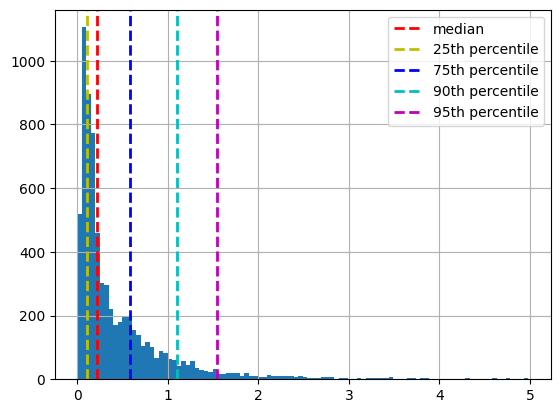

In [6]:
# Filter the data and calculate the median
filtered_data = data[data['Percentage Spread'] < 5]
median_value = filtered_data['Percentage Spread'].median()

# Calculate the percentiles
percentiles = [filtered_data['Percentage Spread'].quantile(i) for i in [0.25, 0.75, 0.90, 0.95]]

# Create the histogram
filtered_data['Percentage Spread'].hist(bins=100)

# Draw a vertical line at the median
plt.axvline(median_value, color='r', linestyle='dashed', linewidth=2, label='median')

# Draw vertical lines at the percentiles
colors = ['y', 'b', 'c', 'm']
labels = ['25th percentile', '75th percentile', '90th percentile', '95th percentile']
for percentile, color, label in zip(percentiles, colors, labels):
    plt.axvline(percentile, color=color, linestyle='dashed', linewidth=2, label=label)

# Add a legend
plt.legend()

# Show the plot
plt.show()

### 4. A Closer Look at the U.S. Bonds... <a class="anchor" id="4"></a>

In [7]:
us_data = data[data['Country'] == 'United States']
us1y = data[(data['Country'] == 'United States') & (data['Years to Maturity'] == 1)]
us2y = data[(data['Country'] == 'United States') & (data['Years to Maturity'] == 2)]
us10y = data[(data['Country'] == 'United States') & (data['Years to Maturity'] == 10)]
us_2_to_5 = data[(data['Country'] == 'United States') & (data['Years to Maturity'] > 2) & (data['Years to Maturity'] <= 5)]
us_5_to_10 = data[(data['Country'] == 'United States') & (data['Years to Maturity'] > 5) & (data['Years to Maturity'] <= 10)]
us_10_to_30 = data[(data['Country'] == 'United States') & (data['Years to Maturity'] > 10) & (data['Years to Maturity'] <= 30)]

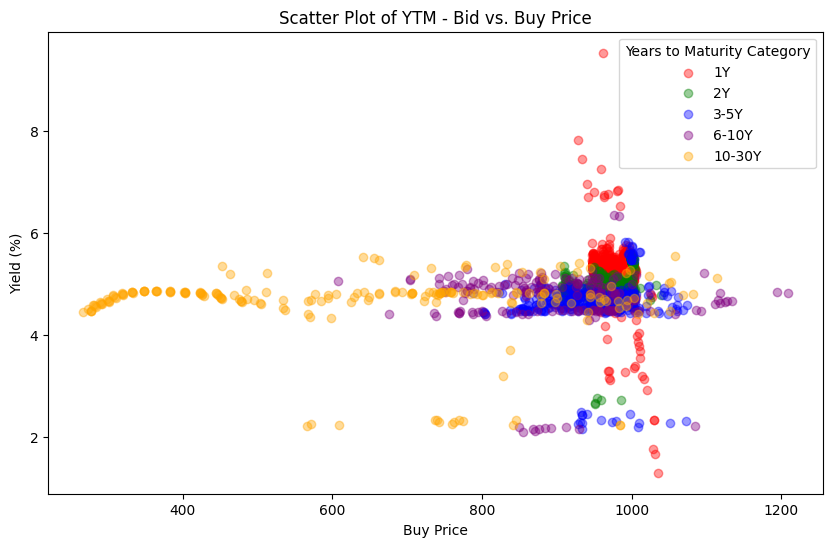

In [8]:
# Assuming 'portfolio' is your DataFrame with bond data
plt.figure(figsize=(10, 6))

# Filtering out negative 'YTM - Ask' values
filtered_data = us_data[us_data['YTM - Ask'] >= 0]

# Creating categorical 'Years to Maturity' bins
bins = [0, 1, 2, 5, 10, 30]
labels = ['1Y', '2Y', '3-5Y', '6-10Y', '10-30Y']
filtered_data['Years to Maturity Category'] = pd.cut(filtered_data['Years to Maturity'], bins=bins, labels=labels)

# Define a color map for the categories
category_colors = {'1Y': 'red', '2Y': 'green', '3-5Y': 'blue', '6-10Y': 'purple', '10-30Y': 'orange'}

# Map the category labels to colors
filtered_data['Color'] = filtered_data['Years to Maturity Category'].map(category_colors)

# Creating scatter plot with discrete colors
for category, color in category_colors.items():
    subset = filtered_data[filtered_data['Years to Maturity Category'] == category]
    plt.scatter(subset['Buy Price'], subset['YTM - Ask'], label=category, color=color, alpha=0.4)

# Adding labels
plt.xlabel('Buy Price')
plt.ylabel('Yield (%)')

# Adding a legend
plt.legend(title='Years to Maturity Category')

# Adding a title
plt.title('Scatter Plot of YTM - Bid vs. Buy Price')

# Show the plot
plt.show()

#### 4.1. US 2-years <a class="anchor" id="41"></a>

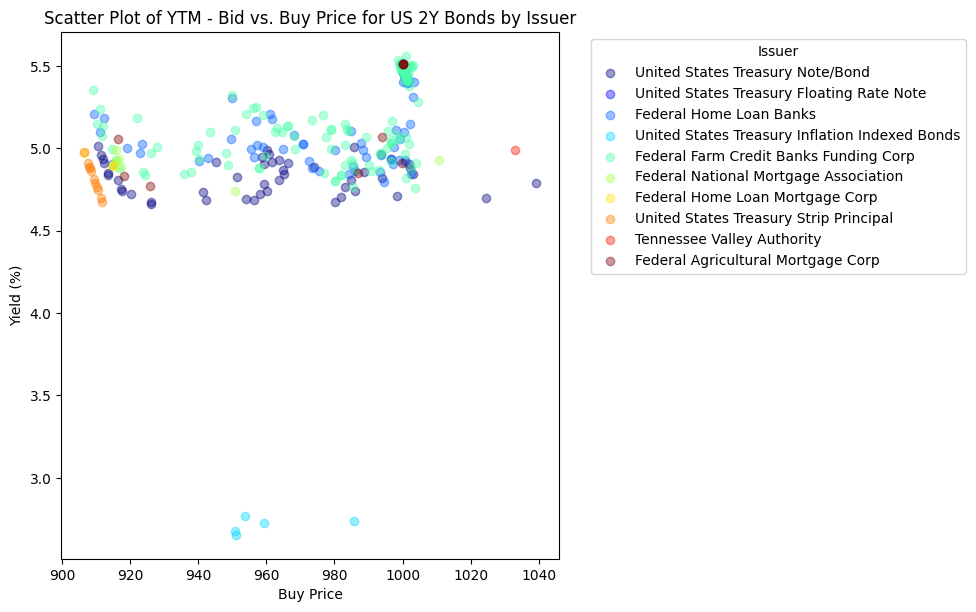

In [9]:
# Assuming us2y is your DataFrame for US bonds with 2 years to maturity
plt.figure(figsize=(10, 6))

# Filtering out negative 'YTM - Ask' values
filtered_us2y = us2y[us2y['YTM - Ask'] >= 0]

# Identify unique issuers
unique_issuers = filtered_us2y['Issuer'].unique()

# Assign a color to each issuer
# If there are too many issuers, consider using a colormap instead
colors = plt.cm.jet(np.linspace(0, 1, len(unique_issuers)))
issuer_colors = dict(zip(unique_issuers, colors))

# Map the issuer to colors
filtered_us2y['Color'] = filtered_us2y['Issuer'].map(issuer_colors)

# Creating scatter plot with discrete colors
for issuer, color in issuer_colors.items():
    subset = filtered_us2y[filtered_us2y['Issuer'] == issuer]
    plt.scatter(subset['Buy Price'], subset['YTM - Ask'], label=issuer, color=color, alpha=0.4)

# Adding labels
plt.xlabel('Buy Price')
plt.ylabel('Yield (%)')

# Adding a legend
plt.legend(title='Issuer', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to make room for the legend
plt.tight_layout()

# Adding a title
plt.title('Scatter Plot of YTM - Bid vs. Buy Price for US 2Y Bonds by Issuer')

# Show the plot
plt.show()

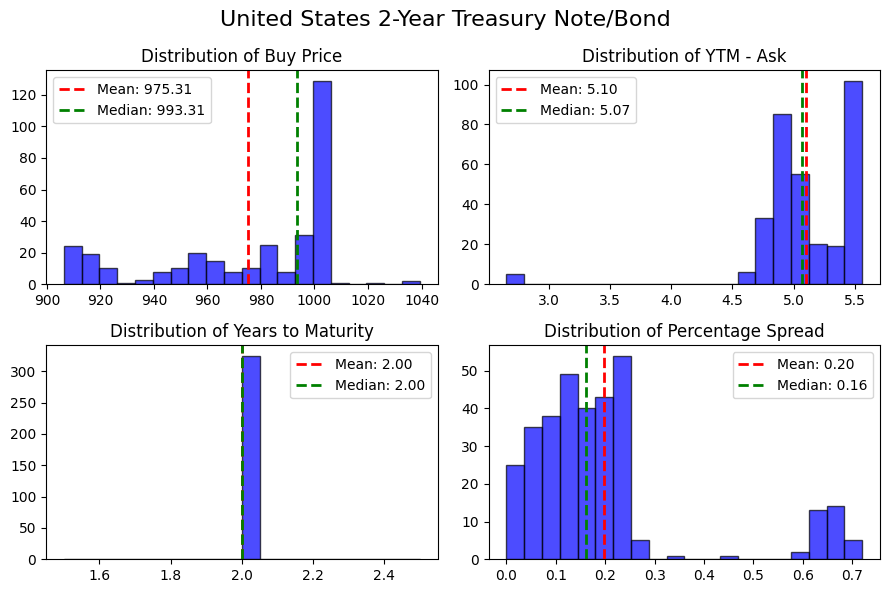

In [10]:
# Create a 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(9, 6))

# Define the columns and titles for each subplot
columns = ["Buy Price", "YTM - Ask", "Years to Maturity", "Percentage Spread"]
titles = ["Distribution of Buy Price", "Distribution of YTM - Ask",
          "Distribution of Years to Maturity", "Distribution of Percentage Spread"]

# Loop through the subplots and create histograms
for i in range(4):
    ax = axes[i // 2, i % 2]
    col = columns[i]
    title = titles[i]
    # Plot the histogram
    ax.hist(us2y[col], bins=20, alpha=0.7, color='b', edgecolor='black')
    # Calculate and plot the mean and median as vertical lines
    mean_val = us2y[col].mean()
    median_val = us2y[col].median()
    ax.axvline(mean_val, color='r', linestyle='dashed', linewidth=2, label=f"Mean: {mean_val:.2f}")
    ax.axvline(median_val, color='g', linestyle='dashed', linewidth=2, label=f"Median: {median_val:.2f}")
    
    ax.set_title(title)
    ax.legend(loc='best')

plt.suptitle("United States 2-Year Treasury Note/Bond", fontsize=16)

plt.tight_layout()
plt.savefig("figures/us2y.png")

# Display the plot
plt.show()

In [11]:
# sort by modified duration
us2y_sorted_by_duration = us2y.sort_values(by='Modified Duration (Buy)', ascending=False)

mean_spread_2y = us2y['Percentage Spread'].mean()
median_spread_2y = us2y['Percentage Spread'].median()
print(f"""Mean percentage spread of buy-sell prices for US 2-yr: {mean_spread_2y}
Median percentage spread of buy-sell prices for US 2-yr: {median_spread_2y}""")

# Exclude the ones with illiquidity and high price spread
subset_us2y_sorted_by_duration = us2y_sorted_by_duration[us2y['Percentage Spread'] <= median_spread_2y]
subset_us2y_sorted_by_duration[['Issuer', 'Cpn', 'YTM - Ask', 'Buy Price', 'DV01', 'Convexity (Buy)', 'Percentage Spread', 'Macaulay Duration (Buy)', 'Modified Duration (Buy)' ]].head(5)

Mean percentage spread of buy-sell prices for US 2-yr: 0.19697924227565872
Median percentage spread of buy-sell prices for US 2-yr: 0.1606218703457926


,Issuer,Cpn,YTM - Ask,Buy Price,DV01,Convexity (Buy),Percentage Spread,Macaulay Duration (Buy),Modified Duration (Buy)
150,United States Treasury Note/Bond,0.25,4.83753,913.540,-0.178,5.47,0.047945,1.996,1.949
240,United States Treasury Note/Bond,0.25,4.847783,913.357,-0.178,5.47,0.054415,1.996,1.949
535,United States Treasury Note/Bond,0.25,4.90745,912.296,-0.178,5.46,0.052066,1.996,1.948
495,United States Treasury Note/Bond,0.25,4.961335,911.339,-0.177,5.45,0.057059,1.996,1.948
371,United States Treasury Note/Bond,0.375,4.741631,917.608,-0.179,5.48,0.048387,1.994,1.948


In [12]:
us2y_sorted_by_yield = subset_us2y_sorted_by_duration.sort_values(by='DV01', ascending=False)
us2y_sorted_by_yield[['Issuer', 'Cpn', 'YTM - Ask', 'Buy Price', 'DV01', 'Convexity (Buy)', 'Percentage Spread', 'Macaulay Duration (Buy)', 'Modified Duration (Buy)']].head(10)

,Issuer,Cpn,YTM - Ask,Buy Price,DV01,Convexity (Buy),Percentage Spread,Macaulay Duration (Buy),Modified Duration (Buy)
4997,Federal Farm Credit Banks Funding Corp,0.36,5.147841,910.101,-0.176,5.44,0.128118,1.994,1.944
5282,Federal Home Loan Banks,0.375,5.100331,911.224,-0.176,5.45,0.111608,1.994,1.944
3327,Federal Farm Credit Banks Funding Corp,0.5,5.354643,909.074,-0.176,5.43,0.077001,1.992,1.940
1178,Federal Home Loan Banks,0.375,4.902012,914.747,-0.177,5.47,0.095108,1.994,1.946
495,United States Treasury Note/Bond,0.25,4.961335,911.339,-0.177,5.45,0.057059,1.996,1.948
1004,United States Treasury Strip Principal,0,4.877,908.128,-0.177,18.16,0.140399,1.816,1.773
5380,Federal Farm Credit Banks Funding Corp,0.45,5.134294,912.031,-0.177,5.45,0.112496,1.993,1.943
1181,Federal Home Loan Banks,0.5,5.180555,912.150,-0.177,5.45,0.077619,1.992,1.942
5438,United States Treasury Strip Principal,0,4.978,906.340,-0.177,18.13,0.033210,1.813,1.769
913,United States Treasury Strip Principal,0,4.81,909.317,-0.177,18.19,0.099525,1.819,1.776


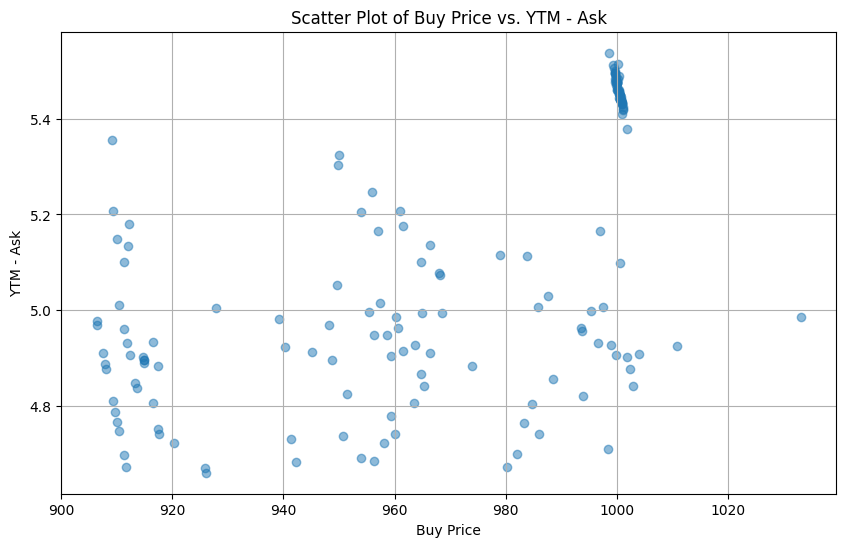

In [13]:
plt.figure(figsize=(10, 6))
plt.scatter(subset_us2y_sorted_by_duration['Buy Price'], subset_us2y_sorted_by_duration['YTM - Ask'], alpha=0.5)
plt.xlabel('Buy Price')
plt.ylabel('YTM - Ask')
plt.title('Scatter Plot of Buy Price vs. YTM - Ask')
plt.grid(True)
plt.show()

In [14]:
# since I assert 2Y yields will decline, for higher duration, drop the higher coupon bonds
final2y = us2y_sorted_by_yield[us2y_sorted_by_yield['Cpn'] <= 3]

In [15]:
excluded_issuers = ["United States Treasury Strip Principal", "Federal National Mortgage Association", "Federal Home Loan Mortgage Corp"]
final2y = final2y[~final2y['Issuer'].isin(excluded_issuers)]

In [16]:
print(f"""
Final subset for US 2yr has:
    Avg Yield: {round(final2y["YTM - Ask"].mean(), 3)}
    Avg Price: {round(final2y["Buy Price"].mean(), 3)}
    Avg Duration: {round(final2y["Macaulay Duration (Buy)"].mean(),3)}
    Avg Modified Duration: {round(final2y["Modified Duration (Buy)"].mean(),3)}
    Avg DV01: {round(final2y['DV01'].mean(), 3)}
""")


Final subset for US 2yr has:
    Avg Yield: 4.938
    Avg Price: 939.037
    Avg Duration: 1.974
    Avg Modified Duration: 1.927
    Avg DV01: -0.181



In [17]:
final2y.shape

(51, 53)

#### 4.2. US 2-to-5-years

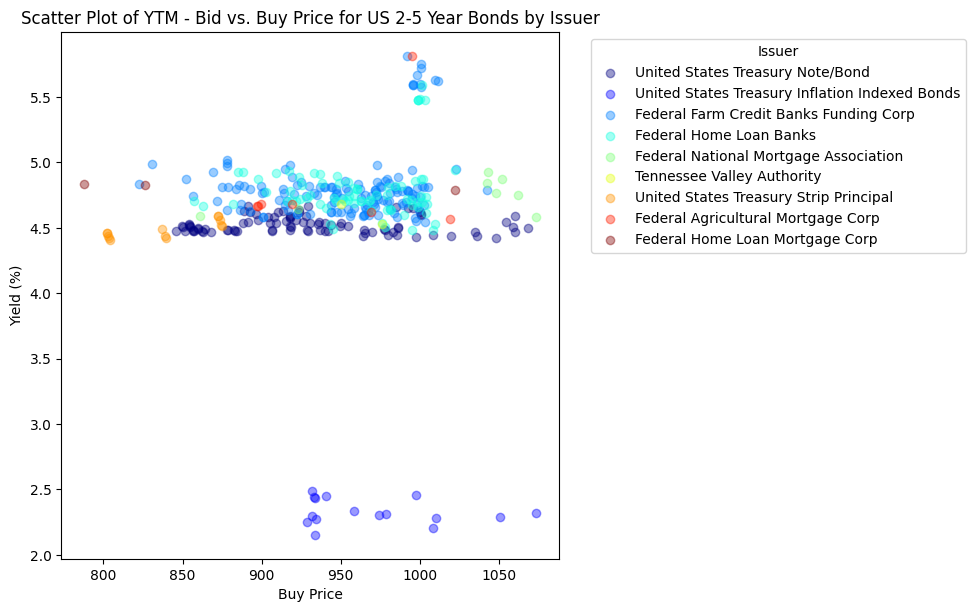

In [18]:
plt.figure(figsize=(10, 6))

filtered_us_2_to_5 = us_2_to_5[us_2_to_5['YTM - Ask'] >= 0]

unique_issuers = filtered_us_2_to_5['Issuer'].unique()

colors = plt.cm.jet(np.linspace(0, 1, len(unique_issuers)))
issuer_colors = dict(zip(unique_issuers, colors))

filtered_us_2_to_5['Color'] = filtered_us_2_to_5['Issuer'].map(issuer_colors)

for issuer, color in issuer_colors.items():
    subset = filtered_us_2_to_5[filtered_us_2_to_5['Issuer'] == issuer]
    plt.scatter(subset['Buy Price'], subset['YTM - Ask'], label=issuer, color=color, alpha=0.4)

plt.xlabel('Buy Price')
plt.ylabel('Yield (%)')
plt.legend(title='Issuer', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.title('Scatter Plot of YTM - Bid vs. Buy Price for US 2-5 Year Bonds by Issuer')
plt.show()

In [19]:
us_2_to_5_sorted_by_duration = us_2_to_5.sort_values(by='Modified Duration (Buy)', ascending=False)

mean_spread_2_to_5 = us_2_to_5['Percentage Spread'].mean()
median_spread_2_to_5 = us_2_to_5['Percentage Spread'].median()
print(f"""Mean percentage spread of buy-sell prices for US 2-5 yr: {mean_spread_2_to_5}
Median percentage spread of buy-sell prices for US 2-5 yr: {median_spread_2_to_5}""")

subset_us_2_to_5_sorted_by_duration = us_2_to_5_sorted_by_duration[us_2_to_5['Percentage Spread'] <= median_spread_2_to_5]

subset_us_2_to_5_sorted_by_duration[['Issuer', 'Cpn', 'YTM - Ask', 'Buy Price', 'Sell Price', 'DV01','Percentage Spread', 'Macaulay Duration (Buy)', 'Modified Duration (Buy)', 'Convexity (Buy)']].head(20)

Mean percentage spread of buy-sell prices for US 2-5 yr: 0.4004094790271306
Median percentage spread of buy-sell prices for US 2-5 yr: 0.27505669502598556


,Issuer,Cpn,YTM - Ask,Buy Price,Sell Price,DV01,Percentage Spread,Macaulay Duration (Buy),Modified Duration (Buy),Convexity (Buy)
439,United States Treasury Inflation Indexed Bonds,0.75,2.153455,933.810,931.645,-0.453,0.231846,4.913,4.861,28.27
607,United States Treasury Inflation Indexed Bonds,0.875,2.274379,934.215,932.318,-0.451,0.203058,4.899,4.844,28.22
379,United States Treasury Note/Bond,1,4.474688,845.862,845.452,-0.404,0.048471,4.877,4.770,26.24
397,United States Treasury Note/Bond,1.125,4.474781,851.403,850.918,-0.405,0.056965,4.863,4.757,26.31
341,United States Treasury Note/Bond,1.25,4.472629,857.036,856.557,-0.406,0.055890,4.849,4.743,26.38
602,United States Treasury Note/Bond,1.25,4.475595,856.915,856.499,-0.407,0.048546,4.849,4.743,26.37
645,United States Treasury Note/Bond,1.25,4.480002,856.736,856.313,-0.406,0.049373,4.848,4.742,26.37
562,United States Treasury Note/Bond,1.375,4.475491,862.464,862.005,-0.408,0.053220,4.834,4.728,26.44
217,United States Treasury Note/Bond,1.375,4.470292,862.676,862.204,-0.407,0.054713,4.834,4.728,26.45
472,United States Treasury Note/Bond,1.5,4.46962,868.250,867.706,-0.409,0.062655,4.821,4.716,26.52


In [20]:
# Sorting us_2_to_5 by yield
us_2_to_5_sorted_by_yield = subset_us_2_to_5_sorted_by_duration.sort_values(by='DV01', ascending=False)

# Displaying the top 5 bonds for us_2_to_5
us_2_to_5_sorted_by_yield[['Issuer', 'Cpn', 'YTM - Ask', 'Buy Price', 'DV01', 'BBG Composite', 'Percentage Spread', 'Macaulay Duration (Buy)', 'Modified Duration (Buy)', 'Convexity (Buy)']].head(20)

,Issuer,Cpn,YTM - Ask,Buy Price,DV01,BBG Composite,Percentage Spread,Macaulay Duration (Buy),Modified Duration (Buy),Convexity (Buy)
5572,Federal Farm Credit Banks Funding Corp,0.55,4.970732,878.191,-0.254,AA+,0.194491,2.978,2.906,10.70
4998,Federal Farm Credit Banks Funding Corp,0.58,4.998645,878.305,-0.254,AA+,0.115222,2.977,2.904,10.69
4375,Federal Farm Credit Banks Funding Corp,0.6,5.020593,878.296,-0.254,AA+,0.115223,2.976,2.903,10.69
3736,United States Treasury Strip Principal,0,4.59,872.717,-0.255,NaN,0.044001,2.618,2.559,36.65
1449,United States Treasury Strip Principal,0,4.592,872.666,-0.255,NaN,0.184607,2.618,2.559,36.65
5104,United States Treasury Strip Principal,0,4.521,874.485,-0.256,NaN,0.140654,2.623,2.565,36.73
1281,United States Treasury Strip Principal,0,4.51,874.768,-0.256,NaN,0.181762,2.624,2.566,36.74
1351,Federal Home Loan Banks,0.875,4.924537,888.332,-0.256,AA+,0.166154,2.965,2.894,10.76
6492,Federal Farm Credit Banks Funding Corp,0.6,4.793602,884.106,-0.256,AA+,0.116728,2.976,2.906,10.75
5912,Federal Home Loan Banks,0.75,4.927004,884.822,-0.256,AA+,0.084085,2.970,2.899,10.74


In [21]:
us_2_to_5_sorted_by_yield.Issuer.value_counts()

Issuer
United States Treasury Note/Bond                  84
Federal Home Loan Banks                           31
Federal Farm Credit Banks Funding Corp            30
United States Treasury Inflation Indexed Bonds    15
United States Treasury Strip Principal             9
Federal National Mortgage Association              7
Federal Home Loan Mortgage Corp                    3
Tennessee Valley Authority                         1
Name: count, dtype: int64

In [22]:
us_2_to_5_sorted_by_yield_filtered = us_2_to_5_sorted_by_yield[us_2_to_5_sorted_by_yield['Buy Price'] < 1000]

In [23]:
excluded_issuers = ["United States Treasury Inflation Indexed Bonds", "Tennessee Valley Authority", 
                    "Federal Home Loan Mortgage Corp", "United States Treasury Strip Principal",
                    "Federal National Mortgage Association"]

us_2_to_5_sorted_by_yield_filtered = us_2_to_5_sorted_by_yield_filtered[~us_2_to_5_sorted_by_yield_filtered['Issuer'].isin(excluded_issuers)]

In [24]:
us_2_to_5_sorted_by_yield_filtered.shape

(133, 53)

In [25]:
us_2_to_5_50 = us_2_to_5_sorted_by_yield_filtered.head(50)

In [26]:
final_2_5 = us_2_to_5_50.copy()

#### 4.3. US 5-to-10-years <a class="anchor" id="43"></a>

In [27]:
us_5_to_10_sorted_by_duration = us_5_to_10.sort_values(by='Modified Duration (Buy)', ascending=False)

# Calculate mean and median percentage spreads for us_5_to_10
mean_spread_5_to_10 = us_5_to_10['Percentage Spread'].mean()
median_spread_5_to_10 = us_5_to_10['Percentage Spread'].median()
print(f"""Mean percentage spread of buy-sell prices for US 5-10 yr: {mean_spread_5_to_10}
Median percentage spread of buy-sell prices for US 5-10 yr: {median_spread_5_to_10}""")

us_5_to_10_sorted_by_duration[['Issuer', 'Cpn', 'YTM - Ask', 'Buy Price', 'Sell Price', 'Percentage Spread', 'Macaulay Duration (Buy)', 'Modified Duration (Buy)', 'Convexity (Buy)']].head(5)

Mean percentage spread of buy-sell prices for US 5-10 yr: 0.7249371259749666
Median percentage spread of buy-sell prices for US 5-10 yr: 0.393802254631931


,Issuer,Cpn,YTM - Ask,Buy Price,Sell Price,Percentage Spread,Macaulay Duration (Buy),Modified Duration (Buy),Convexity (Buy)
10,United States Treasury Inflation Indexed Bonds,1.375,2.167314,929.110,928.547,0.060596,9.347,9.247,101.76
5458,Federal Farm Credit Banks Funding Corp,1.8,5.124105,742.412,734.073,1.123231,9.029,8.803,87.02
272,United States Treasury Inflation Indexed Bonds,0.625,2.150601,875.771,874.883,0.101396,8.745,8.652,81.75
139,United States Treasury Inflation Indexed Bonds,1.125,2.205644,912.224,911.762,0.050645,8.559,8.466,82.90
4440,Federal Farm Credit Banks Funding Corp,3.4,5.18678,861.949,853.266,1.007368,8.423,8.210,91.86


In [28]:
# Create a subset of bonds with percentage spreads less than or equal to the median spread
subset_us_5_to_10_sorted_by_duration = us_5_to_10_sorted_by_duration[us_5_to_10['Percentage Spread'] <= median_spread_5_to_10]

# Display the top 5 bonds for us_5_to_10 sorted by yield
us_5_to_10_sorted_by_yield = subset_us_5_to_10_sorted_by_duration.sort_values(by='YTM - Ask', ascending=False)
us_5_to_10_sorted_by_yield[['Issuer', 'Cpn', 'YTM - Ask', 'Buy Price', 'Sell Price', 'Percentage Spread', 'Macaulay Duration (Buy)', 'Modified Duration (Buy)', 'Convexity (Buy)']].head(5)

,Issuer,Cpn,YTM - Ask,Buy Price,Sell Price,Percentage Spread,Macaulay Duration (Buy),Modified Duration (Buy),Convexity (Buy)
3912,Federal Farm Credit Banks Funding Corp,4.5,5.248246,946.871,944.126,0.289902,7.449,7.259,78.67
5045,Federal Home Loan Banks,7.125,5.214883,1097.333,1094.403,0.267011,5.039,4.911,40.25
4029,Federal Home Loan Banks,4.875,5.152246,980.233,977.419,0.287075,7.372,7.187,79.98
4897,Federal Farm Credit Banks Funding Corp,3.3,5.137899,880.672,877.213,0.392768,7.022,6.846,61.82
4483,Federal Farm Credit Banks Funding Corp,2,5.119301,840.591,838.751,0.218894,5.647,5.506,36.02


In [29]:
excluded_issuers = ["United States Treasury Strip Principal", "Tennessee Valley Authority", "Federal National Mortgage Association", "Federal Home Loan Mortgage Corp"]

us_5_to_10_sorted_by_duration_filtered = us_5_to_10_sorted_by_duration[
    (us_5_to_10_sorted_by_duration['Buy Price'] <= 1000)
    & (us_5_to_10_sorted_by_duration['YTM - Ask'] >= 4.5)
    & (~us_5_to_10_sorted_by_duration['Issuer'].isin(excluded_issuers))
]

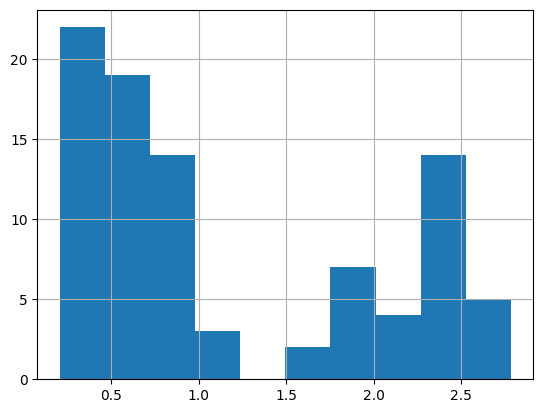

In [30]:
# once again filter for the bid-ask spread to be sure of liquidity
us_5_to_10_sorted_by_duration_filtered['Percentage Spread'].hist()
plt.show()

In [31]:
us_5_to_10_sorted_by_duration_filtered = us_5_to_10_sorted_by_duration_filtered[us_5_to_10_sorted_by_duration_filtered['Percentage Spread'] <= 1]
us_5_to_10_sorted_by_duration_filtered.shape

(55, 53)

In [32]:
final_5_10 = us_5_to_10_sorted_by_duration_filtered.copy()

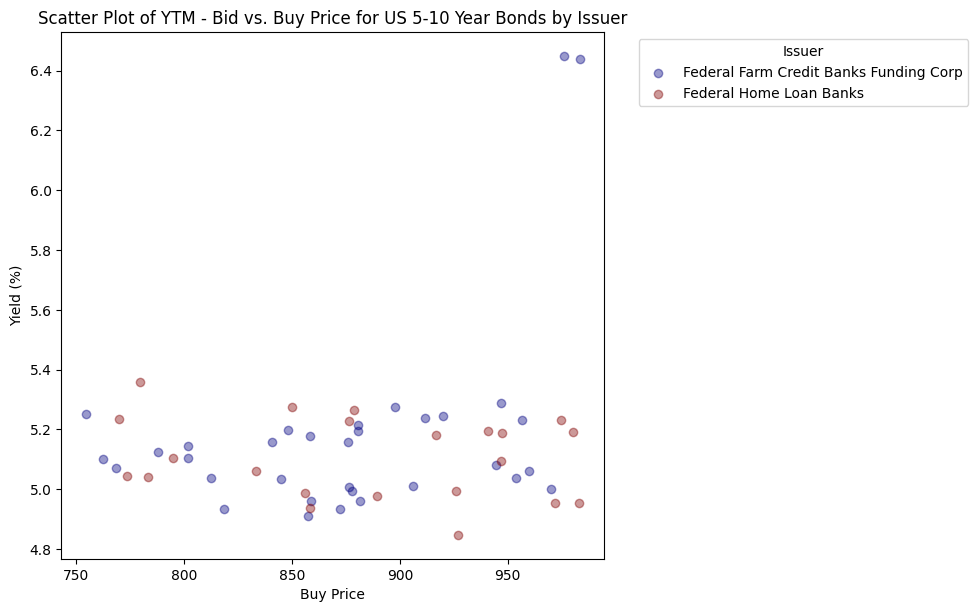

In [33]:
plt.figure(figsize=(10, 6))

filtered_us_5_to_10 = us_5_to_10[us_5_to_10['YTM - Bid'] >= 0]

unique_issuers = us_5_to_10_sorted_by_duration_filtered['Issuer'].unique()
colors = plt.cm.jet(np.linspace(0, 1, len(unique_issuers)))
issuer_colors = dict(zip(unique_issuers, colors))
us_5_to_10_sorted_by_duration_filtered['Color'] = us_5_to_10_sorted_by_duration_filtered['Issuer'].map(issuer_colors)

for issuer, color in issuer_colors.items():
    subset = us_5_to_10_sorted_by_duration_filtered[us_5_to_10_sorted_by_duration_filtered['Issuer'] == issuer]
    plt.scatter(subset['Buy Price'], subset['YTM - Bid'], label=issuer, color=color, alpha=0.4)

plt.xlabel('Buy Price')
plt.ylabel('Yield (%)')
plt.legend(title='Issuer', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.title('Scatter Plot of YTM - Bid vs. Buy Price for US 5-10 Year Bonds by Issuer')
plt.show()

#### 4.4. US >10-years <a class="anchor" id="44"></a>

In [34]:
us_10_to_30_sorted_by_duration = us_10_to_30.sort_values(by='Modified Duration (Buy)', ascending=False)

# Calculate mean and median percentage spreads for us_10_to_30
mean_spread_10_to_30 = us_10_to_30['Percentage Spread'].mean()
median_spread_10_to_30 = us_10_to_30['Percentage Spread'].median()
print(f"""Mean percentage spread of buy-sell prices for US 10-30 yr: {mean_spread_10_to_30}
Median percentage spread of buy-sell prices for US 10-30 yr: {median_spread_10_to_30}""")

us_10_to_30_sorted_by_duration[['Issuer', 'Cpn', 'YTM - Ask', 'Buy Price', 'Sell Price', 'Percentage Spread', 'Macaulay Duration (Buy)', 'Modified Duration (Buy)', 'Convexity (Buy)']].head(5)

Mean percentage spread of buy-sell prices for US 10-30 yr: 0.5432820777951751
Median percentage spread of buy-sell prices for US 10-30 yr: 0.46138196825423167


,Issuer,Cpn,YTM - Ask,Buy Price,Sell Price,Percentage Spread,Macaulay Duration (Buy),Modified Duration (Buy),Convexity (Buy)
115,United States Treasury Inflation Indexed Bonds,0.125,2.213939,565.813,564.256,0.275179,27.303,27.004,591.30
365,United States Treasury Inflation Indexed Bonds,0.125,2.251027,571.600,569.810,0.313156,26.357,26.064,553.40
389,United States Treasury Inflation Indexed Bonds,0.25,2.246088,608.522,605.255,0.536875,24.872,24.596,526.04
50,United States Treasury Inflation Indexed Bonds,1.5,2.247499,841.360,840.350,0.120044,23.020,22.764,716.29
744,United States Treasury Inflation Indexed Bonds,1,2.26092,760.207,756.790,0.449483,21.644,21.402,524.90


In [35]:
# Create a subset of bonds with percentage spreads less than or equal to the median spread
subset_us_10_to_30_sorted_by_duration = us_10_to_30_sorted_by_duration[us_10_to_30['Percentage Spread'] <= median_spread_10_to_30]

# Display the top 5 bonds for us_10_to_30 sorted by yield
us_10_to_30_sorted_by_yield = subset_us_10_to_30_sorted_by_duration.sort_values(by='Buy Price', ascending=False)
us_10_to_30_sorted_by_yield[['Issuer', 'Cpn', 'YTM - Ask', 'Buy Price', 'Sell Price', 'Percentage Spread', 'Macaulay Duration (Buy)', 'Modified Duration (Buy)', 'Convexity (Buy)']].head(5)

,Issuer,Cpn,YTM - Ask,Buy Price,Sell Price,Percentage Spread,Macaulay Duration (Buy),Modified Duration (Buy),Convexity (Buy)
692,Federal Home Loan Banks,5.5,4.785728,1068.545,1064.985,0.333163,9.586,9.362,163.61
694,Federal Home Loan Banks,5.625,5.033651,1052.783,1048.325,0.423449,8.975,8.755,139.57
198,United States Treasury Note/Bond,5,4.480519,1050.769,1049.098,0.159026,9.805,9.590,163.80
518,United States Treasury Note/Bond,4.75,4.439502,1030.420,1028.879,0.149551,9.900,9.685,162.60
30,United States Treasury Note/Bond,4.75,4.619353,1021.096,1020.627,0.045931,16.425,16.054,712.88


In [36]:
us_10_to_30_sorted_by_yield.shape

(101, 53)

In [37]:
selected_issuers = ["United States Treasury Inflation Indexed Bonds", "United States Treasury Note/Bond"]

us_10_to_30_sorted_by_yield = us_10_to_30_sorted_by_yield[
    (us_10_to_30_sorted_by_yield['Issuer'].isin(selected_issuers)) &
    (us_10_to_30_sorted_by_yield['Buy Price'] < 1000)
]

In [38]:
final_over10 = us_10_to_30_sorted_by_yield.copy()

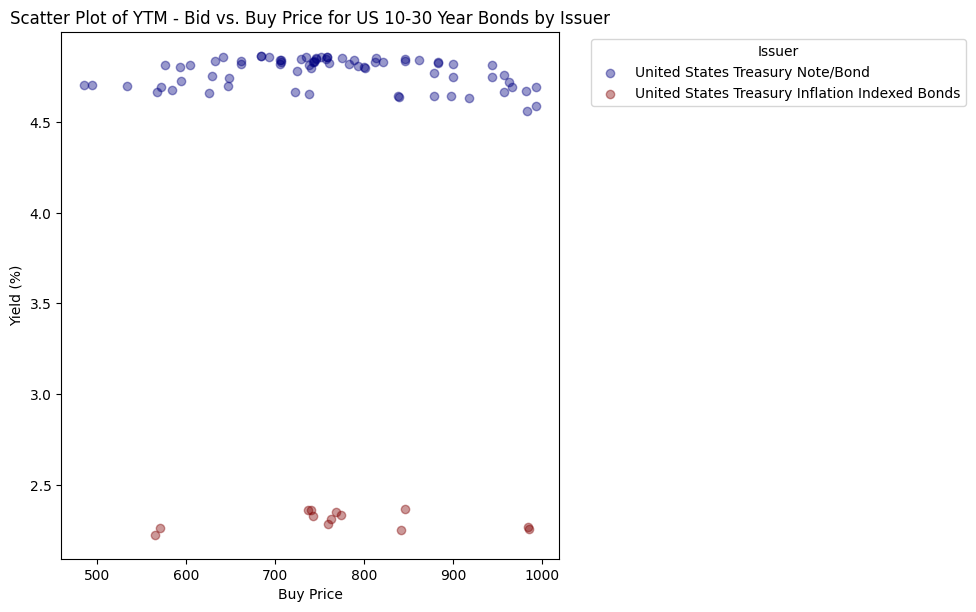

In [39]:
plt.figure(figsize=(10, 6))

filtered_us_10_to_30 = us_10_to_30[us_10_to_30['YTM - Bid'] >= 0]

unique_issuers = us_10_to_30_sorted_by_yield['Issuer'].unique()
colors = plt.cm.jet(np.linspace(0, 1, len(unique_issuers)))
issuer_colors = dict(zip(unique_issuers, colors))
us_10_to_30_sorted_by_yield['Color'] = us_10_to_30_sorted_by_yield['Issuer'].map(issuer_colors)

for issuer, color in issuer_colors.items():
    subset = us_10_to_30_sorted_by_yield[us_10_to_30_sorted_by_yield['Issuer'] == issuer]
    plt.scatter(subset['Buy Price'], subset['YTM - Bid'], label=issuer, color=color, alpha=0.4)

plt.xlabel('Buy Price')
plt.ylabel('Yield (%)')
plt.legend(title='Issuer', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.title('Scatter Plot of YTM - Bid vs. Buy Price for US 10-30 Year Bonds by Issuer')
plt.show()

#### 4.5. US <2-years <a class="anchor" id="45"></a>

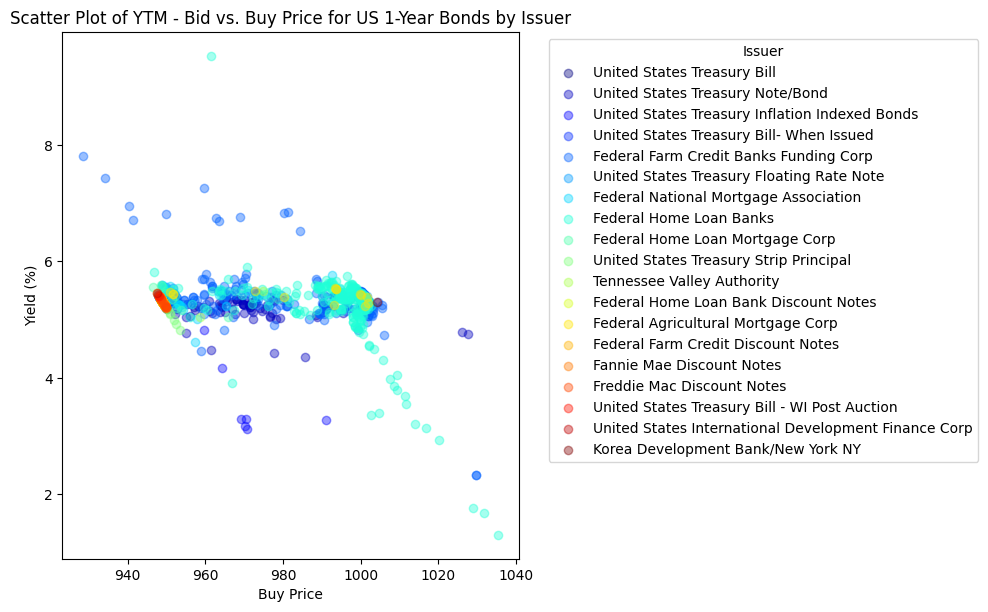

In [40]:
plt.figure(figsize=(10, 6))

filtered_us1y = us1y[us1y['YTM - Ask'] >= 0]

unique_issuers = filtered_us1y['Issuer'].unique()
colors = plt.cm.jet(np.linspace(0, 1, len(unique_issuers)))
issuer_colors = dict(zip(unique_issuers, colors))
filtered_us1y['Color'] = filtered_us1y['Issuer'].map(issuer_colors)

for issuer, color in issuer_colors.items():
    subset = filtered_us1y[filtered_us1y['Issuer'] == issuer]
    plt.scatter(subset['Buy Price'], subset['YTM - Ask'], label=issuer, color=color, alpha=0.4)

plt.xlabel('Buy Price')
plt.ylabel('Yield (%)')
plt.legend(title='Issuer', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.title('Scatter Plot of YTM - Bid vs. Buy Price for US 1-Year Bonds by Issuer')
plt.show()

In [41]:
us1y_sorted_by_duration = us1y.sort_values(by='Modified Duration (Buy)', ascending=False)

# Calculate mean and median percentage spreads for us1y
mean_spread_1y = us1y['Percentage Spread'].mean()
median_spread_1y = us1y['Percentage Spread'].median()
print(f"""Mean percentage spread of buy-sell prices for US 1-Year: {mean_spread_1y}
Median percentage spread of buy-sell prices for US 1-Year: {median_spread_1y}""")

us1y_sorted_by_duration[['Issuer', 'Cpn', 'YTM - Ask', 'Buy Price', 'Sell Price', 'Percentage Spread', 
                         'Macaulay Duration (Buy)', 'Modified Duration (Buy)', 'Convexity (Buy)']].head(5)

Mean percentage spread of buy-sell prices for US 1-Year: 0.26516621854627365
Median percentage spread of buy-sell prices for US 1-Year: 0.1122417380762705


,Issuer,Cpn,YTM - Ask,Buy Price,Sell Price,Percentage Spread,Macaulay Duration (Buy),Modified Duration (Buy),Convexity (Buy)
3680,Federal Home Loan Banks,5.355,-21.630899,1320.932,1319.792,0.086303,0.989,1.109,2.92
1650,Federal Home Loan Banks,4.75,-0.722717,1055.025,922.001,12.608611,0.989,0.993,2.09
2456,Federal Home Loan Banks,4.7,-0.63987,1053.656,920.430,12.644165,0.989,0.992,2.08
175,United States Treasury Inflation Indexed Bonds,0.125,3.126322,970.676,968.713,0.202230,1.000,0.985,1.91
179,United States Treasury Inflation Indexed Bonds,0.125,3.168254,970.276,968.931,0.138620,1.000,0.984,1.91


In [42]:
# Create a subset of bonds with percentage spreads less than or equal to the median spread
subset_us1y_sorted_by_duration = us1y_sorted_by_duration[us1y['Percentage Spread'] <= median_spread_1y]

# Display the top 5 bonds for us1y sorted by yield
us1y_sorted_by_yield = subset_us1y_sorted_by_duration.sort_values(by='YTM - Ask', ascending=False)
us1y_sorted_by_yield[['BBG Composite','Issuer', 'Cpn', 'YTM - Ask', 'Buy Price', 'Sell Price', 'Percentage Spread', 'Macaulay Duration (Buy)', 'Modified Duration (Buy)', 'Convexity (Buy)']].head(5)

,BBG Composite,Issuer,Cpn,YTM - Ask,Buy Price,Sell Price,Percentage Spread,Macaulay Duration (Buy),Modified Duration (Buy),Convexity (Buy)
1538,NaN,Federal Home Loan Banks,5.385,9.529378,961.341,960.597,0.077392,0.987,0.942,1.80
4384,AA+,Federal Farm Credit Banks Funding Corp,2.7,5.786835,970.421,969.741,0.070073,0.993,0.965,1.87
4781,AA+,Federal Farm Credit Banks Funding Corp,1.625,5.781065,960.174,959.306,0.090400,0.996,0.968,1.86
6162,AA+,Federal National Mortgage Association,5,5.763064,992.687,992.451,0.023774,0.988,0.960,1.90
836,NaN,Federal Home Loan Banks,5.385,5.747218,996.528,995.845,0.068538,0.987,0.959,1.91


In [43]:
# first subset for coupon rate less than 3 to check prices
subset_us1y_cpn3 = subset_us1y_sorted_by_duration[subset_us1y_sorted_by_duration['Cpn'] < 3]
subset_us1y_cpn3.sort_values(by='Buy Price', ascending=True, inplace=True)

In [44]:
subset_us1y_zc = subset_us1y_sorted_by_duration[subset_us1y_sorted_by_duration['Cpn'] == 0]
subset_us1y_zc.shape

(60, 53)

In [45]:
subset_us1y_zc_tbill = subset_us1y_zc[subset_us1y_zc['Issuer'] == "United States Treasury Bill"]
subset_us1y_zc_tbill.shape

(45, 53)

In [46]:
subset_us1y_zc_tbill[['Issuer', 'Cpn', 'YTM - Ask', 'Buy Price', 'Sell Price', 'Percentage Spread', 'Macaulay Duration (Buy)', 'Modified Duration (Buy)', 'Convexity (Buy)']].head(5)

,Issuer,Cpn,YTM - Ask,Buy Price,Sell Price,Percentage Spread,Macaulay Duration (Buy),Modified Duration (Buy),Convexity (Buy)
17,United States Treasury Bill,0,5.22188,949.757,949.327,0.045275,0.950,0.926,5.70
82,United States Treasury Bill,0,5.215866,949.813,948.797,0.106968,0.950,0.926,5.70
9,United States Treasury Bill,0,5.196229,949.995,948.937,0.111369,0.950,0.926,5.70
34,United States Treasury Bill,0,5.347913,948.592,948.070,0.055029,0.949,0.924,5.69
37,United States Treasury Bill,0,5.335995,948.702,948.111,0.062296,0.949,0.924,5.69


In [47]:
print(f"""
The strategy for US 1-yr and less than 1-yr
    + Choosing zero-coupon bonds with highest discounts
    + Holding them until their maturity
    + Replace bonds as their mature

Summary Statistics:
    Mean YTM:            {round(subset_us1y_zc_tbill['YTM - Ask'].mean(),3)}
    Mean Price:          {round(subset_us1y_zc_tbill['Buy Price'].mean(),3)}
    Mean MDuration:      {round(subset_us1y_zc_tbill['Modified Duration (Buy)'].mean(),3)}
    Mean Convexity:      {round(subset_us1y_zc_tbill['Convexity (Buy)'].mean(),3)}
    Mean Bid-Ask Spread: {round(subset_us1y_zc_tbill['Percentage Spread'].mean(),3)}

Expected Return: {round((((1000-948.524)/948.524)*100),4)}%
""")


The strategy for US 1-yr and less than 1-yr
    + Choosing zero-coupon bonds with highest discounts
    + Holding them until their maturity
    + Replace bonds as their mature

Summary Statistics:
    Mean YTM:            5.355
    Mean Price:          948.524
    Mean MDuration:      0.923
    Mean Convexity:      5.691
    Mean Bid-Ask Spread: 0.058

Expected Return: 5.427%



In [48]:
final1y = subset_us1y_zc_tbill.copy()

### 5. European Bonds <a class="anchor" id="5"></a>

Since European bonds are denominated in EUR, not USD, first of all, we need to check EURUSD.

[*********************100%%**********************]  1 of 1 completed


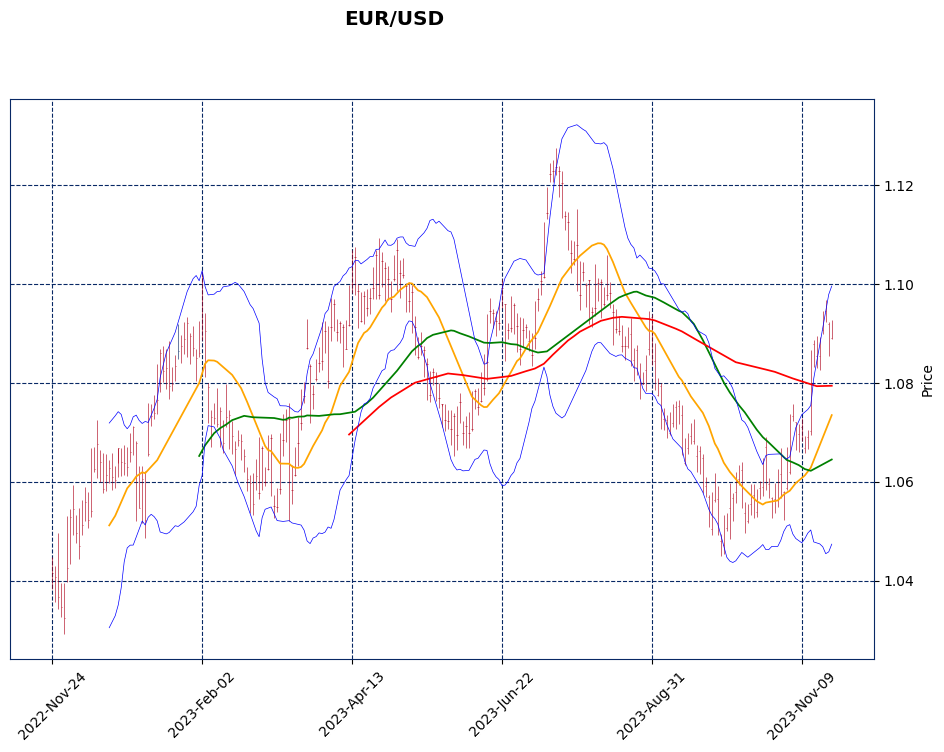


In the last one year for EURUSD:
    Mean: 1.0778400459508786
    Std:  0.01793327446487041
    Min:  1.0324499607086182
    Max:  1.1237596273422241



In [49]:
# Fetch historical data for EUR/USD
eurusd = yf.download("EURUSD=X", start="2022-11-24", end="2023-11-24")

# Calculate Moving Averages (20, 50, and 100 days)
eurusd['SMA_20'] = eurusd['Close'].rolling(window=20).mean()
eurusd['SMA_50'] = eurusd['Close'].rolling(window=50).mean()
eurusd['SMA_100'] = eurusd['Close'].rolling(window=100).mean()

# Calculate Bollinger Bands (20-day, 2 standard deviations)
eurusd['BBL_20_2.0'] = eurusd['Close'].rolling(window=20).mean() - 2 * eurusd['Close'].rolling(window=20).std()
eurusd['BBU_20_2.0'] = eurusd['Close'].rolling(window=20).mean() + 2 * eurusd['Close'].rolling(window=20).std()

# Define additional plots for Moving Averages and Bollinger Bands
apds = [
    mpf.make_addplot(eurusd['SMA_20'], color='orange'),
    mpf.make_addplot(eurusd['SMA_50'], color='green'),
    mpf.make_addplot(eurusd['SMA_100'], color='red'),
    mpf.make_addplot(eurusd['BBU_20_2.0'], color='blue', width=0.5),
    mpf.make_addplot(eurusd['BBL_20_2.0'], color='blue', width=0.5),
]

# Create a candlestick chart with Moving Averages and Bollinger Bands
mpf.plot(eurusd, type='candle', style='sas', addplot=apds, figsize=(12, 8), title='EUR/USD')

print(f"""
In the last one year for EURUSD:
    Mean: {eurusd['Close'].mean()}
    Std:  {eurusd['Close'].std()}
    Min:  {eurusd['Close'].min()}
    Max:  {eurusd['Close'].max()}
""")
mpf.show()

In [50]:
# list of European countries
# bcs using Euro-denominated government bonds did not work
# 1. there are non-European countries issued Euro-denominated bonds
# 2. European countries issued some Dollar-denominated bonds
europe = ['Italy', 'Spain', 'Austria', 'Bulgaria', 'France', 'Germany', 'Hungary', 'Poland', 'Netherlands', 'Greece', 'Belgium', 'Croatia', 
          'Estonia', 'Lithuania', 'Slovakia', 'Slovenia', 'Latvia', 'Portugal', 'Norway', 'San Marino', 'Ireland', 'Finland', 'Denmark', 'Cyprus', 
          'Malta', 'Luxembourg', 'Iceland', 'Sweden', 'Montenegro', 'Czech Republic', 'Bosnia and Herzegovina', 'Kosovo']

europe = data[data['Country'].isin(europe)]

In [51]:
# Group by "Country" and calculate the mean
country_mean = europe.groupby("Country").agg({
    "YTM - Ask": "mean",
    "Cpn": "mean",
    "Years to Maturity": "mean",
    "Buy Price": "mean",
    "Modified Duration (Buy)": "mean"
}).reset_index()

# Display the resulting DataFrame
country_mean

,Country,YTM - Ask,Cpn,Years to Maturity,Buy Price,Modified Duration (Buy)
0,Austria,3.377506,1.652158,8.701754,885.820614,7.225246
1,Belgium,3.629233,1.984749,13.217822,834.441208,10.698074
2,Bosnia and Herzegovina,6.985256,4.75,2.000000,958.941000,1.865000
3,Bulgaria,4.234683,3.475,8.333333,925.114333,6.784417
4,Croatia,3.849648,2.028676,4.823529,927.853176,4.315765
5,Cyprus,3.541578,2.23,7.800000,906.251133,6.271400
6,Czech Republic,3.68631,0.0,2.000000,933.742000,1.779000
7,Denmark,3.834201,2.11947,7.500000,898.941833,6.544556
8,Estonia,4.02775,0.6875,3.333333,942.905667,3.023167
9,Finland,3.687989,1.600727,5.650000,903.580438,5.150187


In [52]:
# Group by "BBG Composite" and calculate the mean
rating_mean = europe.groupby("BBG Composite").agg({
    "YTM - Ask": "mean",
    "Cpn": "mean",
    "Years to Maturity": "mean",
    "Buy Price": "mean",
    "Modified Duration (Buy)": "mean"
}).reset_index()

# Display the resulting DataFrame
rating_mean

,BBG Composite,YTM - Ask,Cpn,Years to Maturity,Buy Price,Modified Duration (Buy)
0,A,3.707267,2.157875,9.750000,858.542238,8.028975
1,A+,3.933856,2.806897,9.827586,905.385276,7.885690
2,A-,3.83687,2.676071,6.797980,946.315121,5.491222
3,AA,3.936801,2.069958,6.540984,908.404393,5.710246
4,AA+,3.653108,2.095028,6.741294,903.316102,5.955637
5,AA-,3.549403,1.946277,7.970833,900.457754,6.833754
6,AAA,4.027897,2.033618,6.414747,903.798935,5.500318
7,B,5.159142,3.375,1.000000,982.826000,0.967000
8,B-,6.985256,4.75,2.000000,958.941000,1.865000
9,BB+,4.121371,3.866356,8.688889,970.205200,6.769644


In [53]:
# high-yields
norway = europe[europe["Country"] == "Norway"]
sweden = europe[europe["Country"] == "Sweden"]
italy = europe[europe["Country"] == "Italy"]
spain = europe[europe["Country"] == "Spain"]
# investment grade
neth = europe[europe["Country"] == "Netherlands"]
france = europe[europe["Country"] == "France"]
germany = europe[europe["Country"] == "Germany"]

### Norway

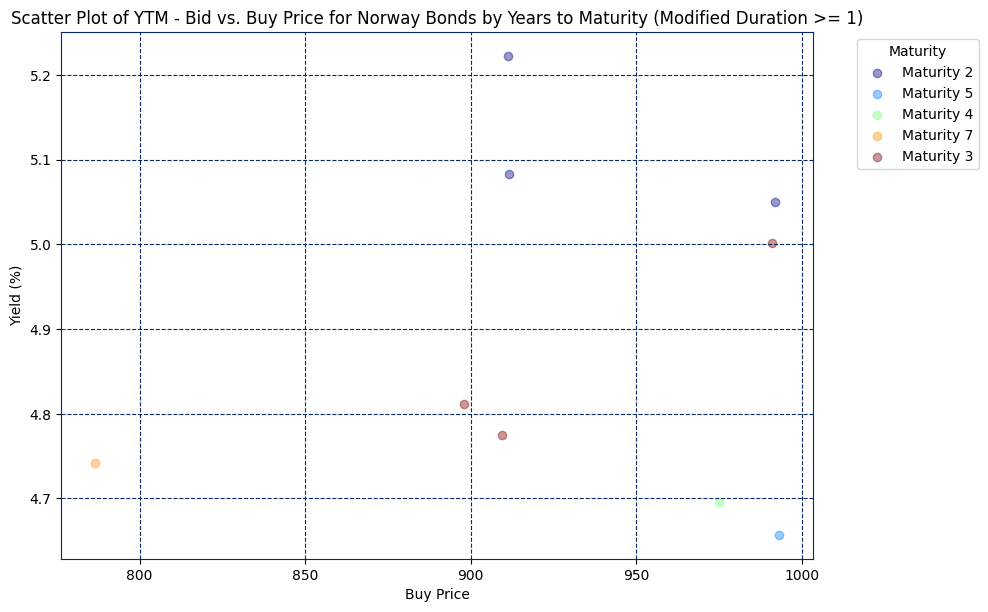

In [54]:
plt.figure(figsize=(10, 6))

filtered_norway = norway[(norway['YTM - Ask'] >= 4.5) & (norway['Modified Duration (Buy)'] >= 1) & (norway["Buy Price"]<=1000)]

unique_maturities = filtered_norway['Years to Maturity'].unique()

colors = plt.cm.jet(np.linspace(0, 1, len(unique_maturities)))
maturity_colors = dict(zip(unique_maturities, colors))

filtered_norway['Color'] = filtered_norway['Years to Maturity'].map(maturity_colors)

for maturity, color in maturity_colors.items():
    subset = filtered_norway[filtered_norway['Years to Maturity'] == maturity]
    plt.scatter(subset['Buy Price'], subset['YTM - Ask'], label=f'Maturity {maturity}', color=color, alpha=0.4)

plt.xlabel('Buy Price')
plt.ylabel('Yield (%)')
plt.legend(title='Maturity', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.title('Scatter Plot of YTM - Bid vs. Buy Price for Norway Bonds by Years to Maturity (Modified Duration >= 1)')
plt.show()

In [55]:
print(filtered_norway[['Years to Maturity', 'Cpn', 'YTM - Ask', 'Buy Price', 'Convexity (Buy)', 'Modified Duration (Buy)']].mean())

final_norway = filtered_norway.copy()

# all Dollar-denominated, no exchange rate risk bearing
print(filtered_norway['Currency'].value_counts())

Years to Maturity            3.444444
Cpn                          2.491667
YTM - Ask                    4.893006
Buy Price                  929.803778
Convexity (Buy)             15.887778
Modified Duration (Buy)      3.213667
dtype: object
Currency
USD    9
Name: count, dtype: int64


### Sweden

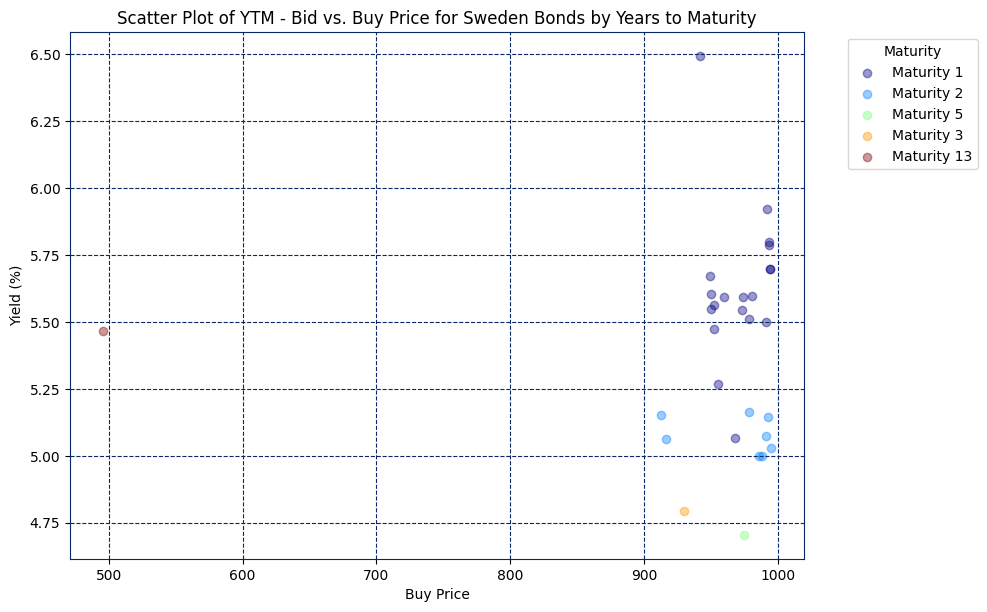

In [56]:
plt.figure(figsize=(10, 6))

filtered_sweden = sweden[(sweden['YTM - Ask'] >= 4.5) & (sweden['Years to Maturity'] <= 15) & (sweden["Buy Price"]<=1000)]

unique_maturities = filtered_sweden['Years to Maturity'].unique()

colors = plt.cm.jet(np.linspace(0, 1, len(unique_maturities)))
maturity_colors = dict(zip(unique_maturities, colors))

filtered_sweden['Color'] = filtered_sweden['Years to Maturity'].map(maturity_colors)

for maturity, color in maturity_colors.items():
    subset = filtered_sweden[filtered_sweden['Years to Maturity'] == maturity]
    plt.scatter(subset['Buy Price'], subset['YTM - Ask'], label=f'Maturity {maturity}', color=color, alpha=0.4)

plt.xlabel('Buy Price')
plt.ylabel('Yield (%)')
plt.legend(title='Maturity', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.title('Scatter Plot of YTM - Bid vs. Buy Price for Sweden Bonds by Years to Maturity')
plt.show()

In [57]:
print(filtered_sweden[['Years to Maturity', 'Cpn', 'YTM - Ask', 'Buy Price', 'Convexity (Buy)', 'Modified Duration (Buy)']].mean())

final_sweden = filtered_sweden.copy()

# all Dollar-denominated, no exchange rate risk bearing
print(filtered_sweden['Currency'].value_counts())
print(filtered_sweden.shape)

Years to Maturity           1.866667
Cpn                           2.7756
YTM - Ask                   5.416996
Buy Price                    953.508
Convexity (Buy)            15.584333
Modified Duration (Buy)       1.5717
dtype: object
Currency
USD    30
Name: count, dtype: int64
(30, 54)


### Italy

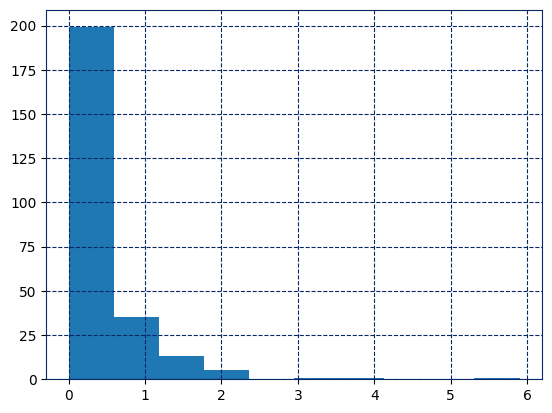

In [58]:
# much higher spreads, lower liquidity than Sweden or Norway
italy["Percentage Spread"].hist()
plt.show()

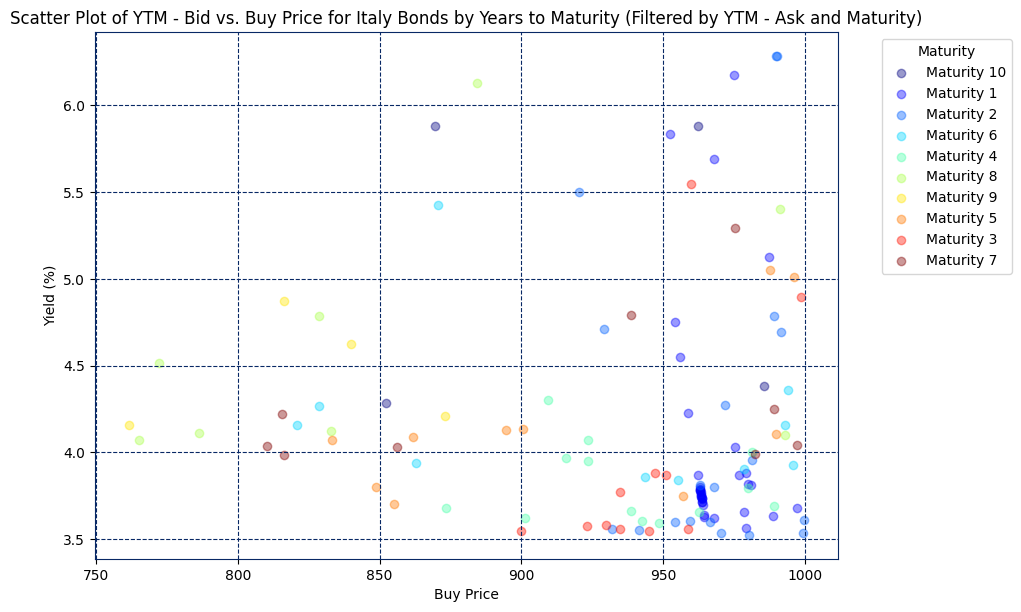

In [59]:
plt.figure(figsize=(10, 6))

# Filter Italy DataFrame based on YTM - Ask >= 3.5 and Years to Maturity <= 20
filtered_italy = italy[(italy['YTM - Ask'] >= 3.5) & (italy['Years to Maturity'] <= 10) & (italy['Buy Price'] <= 1000) & (italy['Percentage Spread']<=1)]

unique_maturities = filtered_italy['Years to Maturity'].unique()

colors = plt.cm.jet(np.linspace(0, 1, len(unique_maturities)))
maturity_colors = dict(zip(unique_maturities, colors))

filtered_italy['Color'] = filtered_italy['Years to Maturity'].map(maturity_colors)

for maturity, color in maturity_colors.items():
    subset = filtered_italy[filtered_italy['Years to Maturity'] == maturity]
    plt.scatter(subset['Buy Price'], subset['YTM - Ask'], label=f'Maturity {maturity}', color=color, alpha=0.4)

plt.xlabel('Buy Price')
plt.ylabel('Yield (%)')
plt.legend(title='Maturity', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.title('Scatter Plot of YTM - Bid vs. Buy Price for Italy Bonds by Years to Maturity (Filtered by YTM - Ask and Maturity)')
plt.show()

In [60]:
filtered_italy.shape

(124, 54)

In [61]:
sorted_italy = filtered_italy.sort_values(by=['Cpn', 'YTM - Ask'], ascending=[False, False])

In [62]:
final_italy = sorted_italy.head(15)
final_italy.shape

(15, 54)

In [63]:
print(final_italy[['Years to Maturity', 'Cpn', 'YTM - Ask', 'Buy Price', 'Convexity (Buy)', 'Modified Duration (Buy)']].mean())

Years to Maturity            5.533333
Cpn                          4.732533
YTM - Ask                    5.325429
Buy Price                  971.134933
Convexity (Buy)             39.957333
Modified Duration (Buy)      4.632733
dtype: object


### France

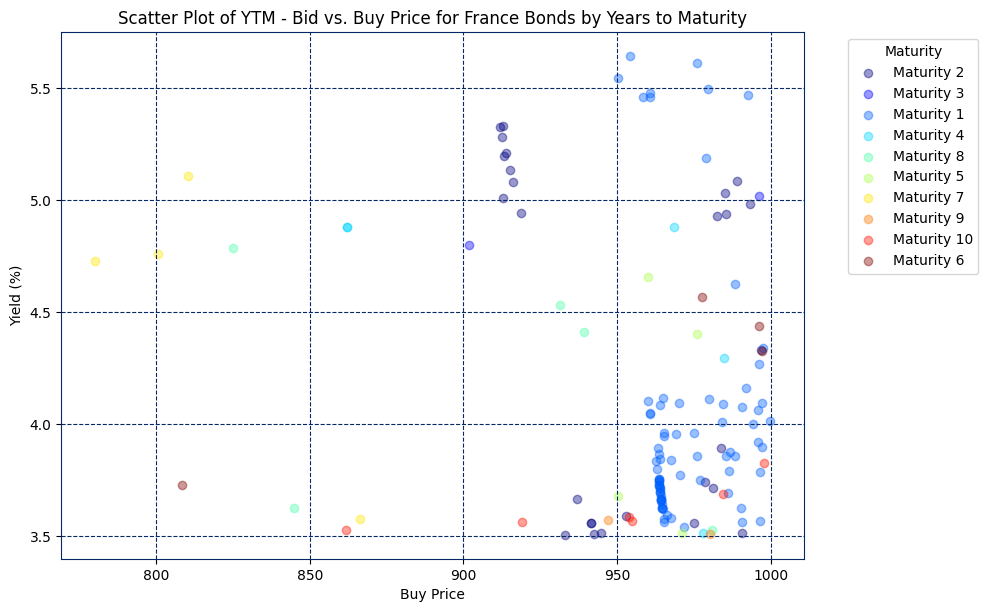

In [64]:
plt.figure(figsize=(10, 6))

filtered_france = france[(france['YTM - Ask'] >= 3.5) & (france['Buy Price'] <= 1000) & (france['Years to Maturity']<=10) & (france['Percentage Spread'] < 1)]

unique_maturities = filtered_france['Years to Maturity'].unique()

colors = plt.cm.jet(np.linspace(0, 1, len(unique_maturities)))
maturity_colors = dict(zip(unique_maturities, colors))

filtered_france['Color'] = filtered_france['Years to Maturity'].map(maturity_colors)

for maturity, color in maturity_colors.items():
    subset = filtered_france[filtered_france['Years to Maturity'] == maturity]
    plt.scatter(subset['Buy Price'], subset['YTM - Ask'], label=f'Maturity {maturity}', color=color, alpha=0.4)

plt.xlabel('Buy Price')
plt.ylabel('Yield (%)')
plt.legend(title='Maturity', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.title('Scatter Plot of YTM - Bid vs. Buy Price for France Bonds by Years to Maturity')
plt.show()

In [65]:
filtered_france.shape

(139, 54)

In [66]:
sorted_france = filtered_france.sort_values(by=['YTM - Ask'], ascending=[False])

In [67]:
sorted_france[['Issuer', 'Cpn', 'Years to Maturity', 'YTM - Ask', 'Buy Price', 'Sell Price', 'Percentage Spread', 'Macaulay Duration (Buy)', 'Modified Duration (Buy)', 'Convexity (Buy)']].head(40)

final_france = sorted_france.head(40)

print(final_france[['Years to Maturity', 'Cpn', 'YTM - Ask', 'Buy Price', 'Convexity (Buy)', 'Modified Duration (Buy)', 'DV01']].mean())

Years to Maturity                 3.1
Cpn                          2.384375
YTM - Ask                    5.016379
Buy Price                  936.164425
Convexity (Buy)               15.9275
Modified Duration (Buy)      2.856775
DV01                         -0.26045
dtype: object


### Germany

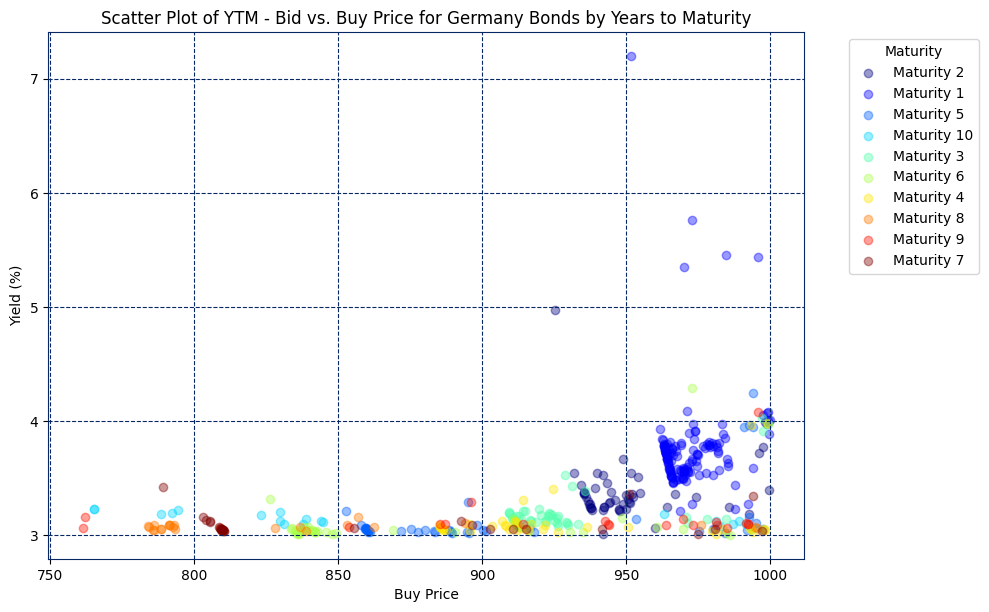

In [68]:
plt.figure(figsize=(10, 6))

filtered_germany = germany[(germany['YTM - Ask'] >= 3) & (germany['Years to Maturity']<=10) & (germany['Percentage Spread'] < 1) & (germany['Buy Price'] < 1000)]

unique_maturities = filtered_germany['Years to Maturity'].unique()

colors = plt.cm.jet(np.linspace(0, 1, len(unique_maturities)))
maturity_colors = dict(zip(unique_maturities, colors))

filtered_germany['Color'] = filtered_germany['Years to Maturity'].map(maturity_colors)

for maturity, color in maturity_colors.items():
    subset = filtered_germany[filtered_germany['Years to Maturity'] == maturity]
    plt.scatter(subset['Buy Price'], subset['YTM - Ask'], label=f'Maturity {maturity}', color=color, alpha=0.4)

plt.xlabel('Buy Price')
plt.ylabel('Yield (%)')
plt.legend(title='Maturity', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.title('Scatter Plot of YTM - Bid vs. Buy Price for Germany Bonds by Years to Maturity')
plt.show()

In [69]:
sorted_germany = filtered_germany.sort_values(by=['Years to Maturity', 'YTM - Ask'], ascending=[True, False])

# Initialize an empty DataFrame to store the selected rows
final_germany = pd.DataFrame()

# Iterate through each unique year of maturity
unique_years = sorted_germany['Years to Maturity'].unique()
rows_per_year = 4
for year in unique_years:
    # Select the top 4 rows with the highest YTM - Ask for the current year
    year_subset = sorted_germany[sorted_germany['Years to Maturity'] == year].head(rows_per_year)
    final_germany = pd.concat([final_germany, year_subset])
    
# Verify that you have selected 40 rows as intended
print(final_germany.shape)

(40, 54)


In [70]:
print(final_germany[['Years to Maturity', 'Cpn', 'YTM - Ask', 'Buy Price', 'Convexity (Buy)', 'Modified Duration (Buy)', 'DV01']].mean())

Years to Maturity               5.5
Cpn                        2.370714
YTM - Ask                   3.83846
Buy Price                  923.4959
Convexity (Buy)             42.1715
Modified Duration (Buy)     5.09015
DV01                       -0.45465
dtype: object


### 6. Emerging Market Bonds <a class="anchor" id="6"></a>

In [71]:
junk = data[data['BBG Composite'].isin(['BB+', 'BB', 'BB-', 'BBB', 'BBB-','BBB+'])]

junk.Country.unique()

array(['Brazil', 'Philippines', 'Hungary', 'South Africa', 'Uzbekistan',
       'Panama', 'United Arab Emirates', 'Colombia', 'Indonesia',
       'Mexico', 'Uruguay', 'Peru', 'Thailand', 'India', 'Spain', 'Italy',
       'Oman', 'Dominica', 'Vietnam', 'Ivory Coast', 'Serbia', 'Paraguay',
       'Morocco', 'Sharjah', 'Kazakhstan', 'Guatemala',
       'Trinidad & Tobago', 'Georgia', 'Croatia', 'Malaysia', 'Bulgaria',
       'Greece', 'North Macedonia', 'Cyprus', 'Andorra', 'Portugal'],
      dtype=object)

In [72]:
junk_grouped = junk.groupby('Country').agg({
    'YTM - Ask': 'mean',
    'Cpn': 'mean',
    'Buy Price': 'mean',
    'Percentage Spread': 'mean',
    'Convexity (Buy)': 'mean',
    'Modified Duration (Buy)': 'mean'
}).reset_index()

# Display the grouped and aggregated DataFrame
junk_grouped

,Country,YTM - Ask,Cpn,Buy Price,Percentage Spread,Convexity (Buy),Modified Duration (Buy)
0,Andorra,3.984768,1.25,834.372000,0.881262,48.550000,6.560000
1,Brazil,6.016807,6.588235,985.794294,1.047249,81.801176,4.970353
2,Bulgaria,4.234683,3.475,925.114333,0.854311,90.822500,6.784417
3,Colombia,6.790731,7.520833,1002.493667,0.976888,78.308333,4.954000
4,Croatia,3.865822,2.711364,912.726818,0.907050,62.905455,6.063727
5,Cyprus,3.514702,2.157143,900.018143,1.376795,107.738571,6.649857
6,Dominica,7.300603,6.235417,915.575167,1.043793,146.617500,6.459667
7,Georgia,7.060669,2.75,920.890000,0.754270,5.370000,1.891000
8,Greece,4.091033,3.71975,957.977850,0.721652,95.771000,6.731225
9,Guatemala,6.649565,4.583333,939.286000,0.688466,13.676667,3.000000


In [73]:
# selected EMs
colombia     = data[data['Country'] == 'Colombia']
south_africa = data[data['Country'] == 'South Africa']
indonesia    = data[data['Country'] == 'Indonesia']
uruguay      = data[data['Country'] == 'Uruguay']
mexico       = data[data['Country'] == 'Mexico']
thailand     = data[data['Country'] == 'Thailand']
philippines  = data[data['Country'] == 'Philippines']
brazil       = data[data['Country'] == 'Brazil']
dubai        = data[data['Country'] == 'Dubai']
peru         = data[data['Country'] == 'Peru']
singapore    = data[data['Country'] == 'Singapore']

In [74]:
indonesia[(indonesia['Years to Maturity'] <= 10) &(indonesia['Percentage Spread'] <= 1) & (indonesia['Buy Price']<=1000) & (indonesia['BBG Composite']=="BBB")][['BBG Composite', 'Percentage Spread', 'YTM - Ask', 'Cpn', 'Buy Price', 'Macaulay Duration (Buy)', 'Modified Duration (Buy)', 'Convexity (Buy)', 'Maturity', 'Years to Maturity']]
final_indonesia = indonesia.copy()

In [75]:
philippines_filtered = philippines[(philippines['Years to Maturity'] <= 10) & (philippines['Percentage Spread']<=1) & (~data['BBG Composite'].isna())]
print(philippines_filtered[['Years to Maturity', 'Cpn', 'YTM - Ask', 'Buy Price', 'Convexity (Buy)', 'Modified Duration (Buy)', 'DV01']].mean())
final_philippines = philippines_filtered.copy()

Years to Maturity              5.25
Cpn                         4.45345
YTM - Ask                  5.039445
Buy Price                  965.9779
Convexity (Buy)              36.112
Modified Duration (Buy)     4.50255
DV01                        -0.4247
dtype: object


In [76]:
hungary_filtered = data[(data['Country'] == 'Hungary') & (data['Years to Maturity'] <= 10) & (data['Percentage Spread'] <= 1) & (~data['BBG Composite'].isna())]
print(hungary_filtered[['Years to Maturity', 'Cpn', 'YTM - Ask', 'Buy Price', 'Convexity (Buy)', 'Modified Duration (Buy)']].mean())
final_hungary = hungary_filtered.copy()

Years to Maturity            4.666667
Cpn                          3.916667
YTM - Ask                    5.278843
Buy Price                  953.204583
Convexity (Buy)             30.356667
Modified Duration (Buy)      3.981167
dtype: object


In [77]:
peru_filtered = peru[(peru['Years to Maturity'] <= 10) & (peru['Percentage Spread'] <= 1) & (~data['BBG Composite'].isna())]
print(peru_filtered[['Years to Maturity', 'Cpn', 'YTM - Ask', 'Buy Price', 'Convexity (Buy)', 'Modified Duration (Buy)', 'DV01']].mean())
final_peru = peru_filtered.copy()

Years to Maturity               4.2
Cpn                          4.1638
YTM - Ask                  4.995689
Buy Price                  954.0472
Convexity (Buy)              23.094
Modified Duration (Buy)      3.7684
DV01                         -0.348
dtype: object


### 7. Model Portfolio <a class="anchor" id="7"></a>

1. Convert all values of EUR-denominated bonds to USD values
2. Build portfolio with chosen weights
3. Calculate portfolio metrics

In [78]:
# Download EUR/USD exchange rate on November 24, 2023
eurusd = yf.download('EURUSD=X', start='2023-11-24', end='2023-11-25')

exchange_rate = eurusd.iloc[0, 3]
exchange_rate

[*********************100%%**********************]  1 of 1 completed


1.0906314849853516

In [79]:
# Columns to convert
columns_to_convert = ['YTM - Ask', 'YTM - Bid', 'Buy Price', 'Sell Price']

# Create new columns with the original values in EUR
for column in columns_to_convert:
    original_column_name = f'{column} (EUR)'
    final_france[original_column_name] = final_france[column]

# Convert the selected columns to USD
final_france[columns_to_convert] = final_france[columns_to_convert] * exchange_rate

In [80]:
# Create new columns with the original values in EUR
for column in columns_to_convert:
    original_column_name = f'{column} (EUR)'
    final_germany[original_column_name] = final_germany[column]

# Convert the selected columns to USD
final_germany[columns_to_convert] = final_germany[columns_to_convert] * exchange_rate

In [81]:
# Create new columns with the original values in EUR
for column in columns_to_convert:
    original_column_name = f'{column} (EUR)'
    final_indonesia[original_column_name] = final_indonesia[column]

# Convert the selected columns to USD
final_indonesia[columns_to_convert] = final_indonesia[columns_to_convert] * exchange_rate

In [82]:
# Create new columns with the original values in EUR
for column in columns_to_convert:
    original_column_name = f'{column} (EUR)'
    final_peru[original_column_name] = final_peru[column]

# Convert the selected columns to USD
final_peru[columns_to_convert] = final_peru[columns_to_convert] * exchange_rate

In [83]:
# Create new columns with the original values in EUR
for column in columns_to_convert:
    original_column_name = f'{column} (EUR)'
    final_hungary[original_column_name] = final_hungary[column]

# Convert the selected columns to USD
final_hungary[columns_to_convert] = final_hungary[columns_to_convert] * exchange_rate

In [84]:
# Create new columns with the original values in EUR
for column in columns_to_convert:
    original_column_name = f'{column} (EUR)'
    final_italy[original_column_name] = final_italy[column]

# Convert the selected columns to USD
final_italy[columns_to_convert] = final_italy[columns_to_convert] * exchange_rate

In [85]:
# List of all dataframes and their corresponding category shares
dfs = [(final1y, 0.10), (final2y, 0.25), (final_2_5, 0.20), (final_5_10, 0.15), (final_over10, 0.05),
       (final_sweden, 0.05), (final_norway, 0.05), (final_france, 0.05), (final_germany, 0.05),
       (final_italy, 0.01), (final_hungary, 0.01), (final_philippines, 0.01), (final_indonesia, 0.01), (final_peru, 0.01)]

# Perform operations on each dataframe
for df, share in dfs:
    df['Total Category Share (%)'] = share
    df['Share per Bond'] = share / len(df)

# Concatenate all dataframes into the portfolio
portfolio = pd.concat([df for df, share in dfs], axis=0, ignore_index=True)

# Total Portfolio Value
total_portfolio_value = 10_000_000

# Create "Amount per Bond" and "Number of Bond" columns in the "portfolio" DataFrame
portfolio['Amount per Bond'] = portfolio['Share per Bond'] * total_portfolio_value
portfolio['Number of Bond'] = portfolio['Amount per Bond'] / portfolio['Buy Price']

In [86]:
#  Apply the calculate_portfolio_metrics function to the portfolio DataFrame
portfolio_metrics = calculate_portfolio_metrics(
    portfolio_df=portfolio,
    weight_col='Share per Bond',
    num_bonds_col='Number of Bond',
    price_col='Buy Price',
    ytm_col='YTM - Ask',
    maturity_col='Years to Maturity',
    coupon_col='Cpn'
)

portfolio_metrics

,Metric,Value
0,YTM,4.968585
1,Price,929.837205
2,Coupon,2.067979
3,Time-to-Maturity,4.375899
4,Duration,4.375899
5,Modified Duration,4.174882
6,Convexity,42.581004
7,DV01,-0.295131
8,Pct Bid-Ask Spread,0.200117
9,5-yr CDS Spread,51.747200


In [87]:
portfolio_grouped = portfolio.groupby('Country').agg({
    'Cpn': 'mean',
    'YTM - Ask': 'mean',
    'Years to Maturity': 'mean',
    'Modified Duration (Buy)': 'mean',
    'DV01': 'mean'
}).reset_index()

# Display the grouped and aggregated DataFrame
portfolio_grouped

,Country,Cpn,YTM - Ask,Years to Maturity,Modified Duration (Buy),DV01
0,France,2.384375,5.471021,3.100000,2.856775,-0.260450
1,Germany,2.370714,4.186346,5.500000,5.090150,-0.454650
2,Hungary,3.916667,5.757273,4.666667,3.981167,-0.371583
3,Indonesia,4.028814,5.67398,9.525424,6.400169,-0.564847
4,Italy,4.732533,5.808081,5.533333,4.632733,-0.443467
5,Norway,2.491667,4.893006,3.444444,3.213667,-0.293444
6,Peru,4.1638,5.448456,4.200000,3.768400,-0.348000
7,Philippines,4.45345,5.039445,5.250000,4.502550,-0.424700
8,Sweden,2.7756,5.416996,1.866667,1.571700,-0.152200
9,United States,1.992774,4.825204,8.947917,6.866830,-0.546896


### Export data

In [88]:
country_to_value = {
    'France'        : 'AA', 
    'Germany'       : 'AAA',
    'Indonesia'     : 'BBB', 
    'Italy'         : 'BBB-',
    'Sweden'        : 'AA+',
    'United States' : 'AA+' 
}

# Fill NaN values in "BBG Composite" based on the mapping
portfolio['BBG Composite'] = portfolio.apply(lambda row: country_to_value[row['Country']] if pd.isna(row['BBG Composite']) else row['BBG Composite'], axis=1)

In [90]:
portfolio.to_excel(PROJECT_DIR / "portfolio.xlsx")

### 8. Monte Carlo Simulations and Value-at-Risk <a class="anchor" id="8"></a>

In [91]:
# Number of simulations
num_simulations = 500

# Store the initial total portfolio price
initial_portfolio_price = (portfolio['Buy Price'] * portfolio['Number of Bond']).sum()

# Store the rates of return for each simulation
rates_of_return = []

# Run the simulations
for _ in range(num_simulations):
    # Generate a random 'YTM - Ask' value for each bond in the portfolio
    portfolio['Simulated YTM - Ask'] = portfolio['YTM - Ask'] * (1 + np.random.uniform(-1, 0.5, len(portfolio)))

    # Calculate the new bond price for each bond in the portfolio
    portfolio['Simulated Bond Price'] = portfolio.apply(lambda row: calculate_bond_price(face_value=row['Face Value'], years_to_maturity=row['Years to Maturity'], ytm_ask=row['Simulated YTM - Ask'], ytm_bid=row['YTM - Bid'], coupon_rate=row['Cpn'], buying=True), axis=1)

    # Calculate the total portfolio price
    total_portfolio_price = (portfolio['Simulated Bond Price'] * portfolio['Number of Bond']).sum()

    # Calculate the rate of return
    rate_of_return = (total_portfolio_price - initial_portfolio_price) / initial_portfolio_price

    # Store the rate of return
    rates_of_return.append(rate_of_return)

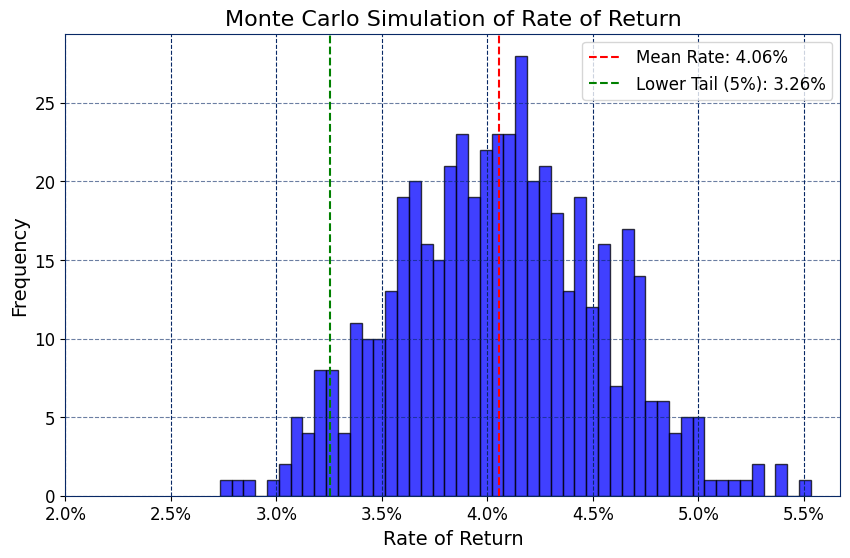

In [92]:
# Customize the plot
plt.figure(figsize=(10, 6))  # Set figure size
plt.hist(rates_of_return, bins=50, alpha=0.75, color='blue', edgecolor='black')  # Specify color and edgecolor
plt.xlabel('Rate of Return', fontsize=14)  # Set x-axis label and font size
plt.ylabel('Frequency', fontsize=14)  # Set y-axis label and font size
plt.title('Monte Carlo Simulation of Rate of Return', fontsize=16)  # Set title and font size
plt.grid(axis='y', linestyle='--', alpha=0.6)  # Add grid lines

# Set custom x-axis ticks and labels
x_ticks = np.arange(0.02, 0.06, 0.005)
x_tick_labels = ['{:,.1%}'.format(x) for x in x_ticks]
plt.xticks(x_ticks, x_tick_labels, fontsize=12)

plt.yticks(fontsize=12)  # Set tick label font size

# Add a vertical line at the mean
mean_rate = np.mean(rates_of_return)
plt.axvline(mean_rate, color='red', linestyle='--', label='Mean Rate: {:.2%}'.format(mean_rate))

# Add a vertical line for the lower tail of 5%
percentile_05 = np.percentile(rates_of_return, 5)
plt.axvline(percentile_05, color='green', linestyle='--', label='Lower Tail (5%): {:.2%}'.format(percentile_05))

# Add legend
plt.legend(fontsize=12)

plt.show()

### 9. Using Technical Analysis Tools for Shorter Term Trades <a class="anchor" id="9"></a>

[*********************100%%**********************]  1 of 1 completed


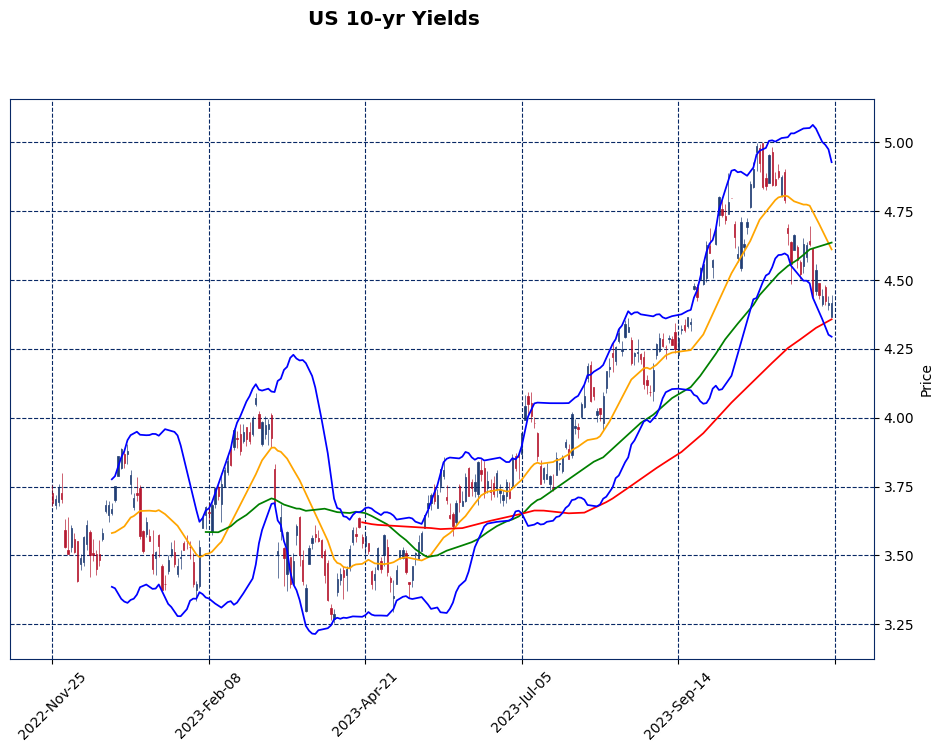

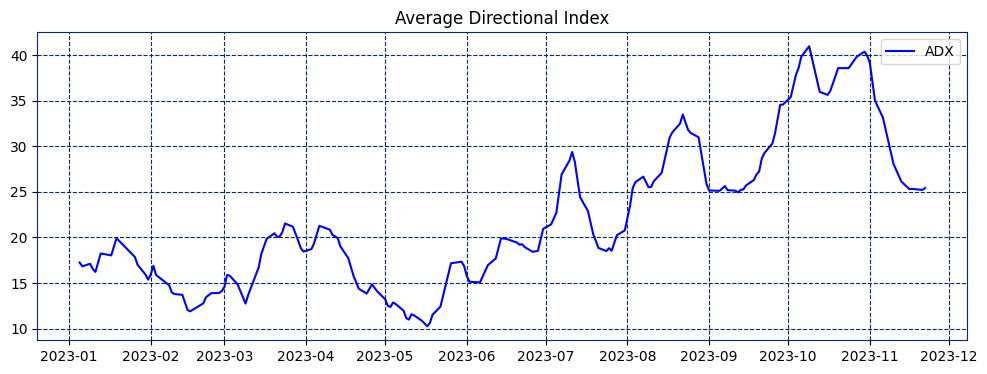

In [93]:
# Define the ticker symbol for the U.S. 10-Year Treasury yield
ticker_symbol = "^TNX"

# Specify the start and end dates
start_date = "2022-11-24"  # Start date
end_date = "2023-11-24"    # End date

# Fetch historical data for the specified date range
yield10y = yf.download(ticker_symbol, start=start_date, end=end_date)

# Calculate ADX, Moving Average, and Bollinger Bands
yield10y.ta.adx(append=True)
yield10y.ta.sma(close='Close', length=20, append=True)
yield10y.ta.sma(close='Close', length=50, append=True)
yield10y.ta.sma(close='Close', length=100, append=True)
yield10y.ta.bbands(close='Close', length=20, std=2, append=True)

# Define additional plots for Moving Average and Bollinger Bands
apds = [mpf.make_addplot(yield10y['SMA_20'], color='orange'),
        mpf.make_addplot(yield10y['SMA_50'], color='green'),
        mpf.make_addplot(yield10y['SMA_100'], color='red'),
        mpf.make_addplot(yield10y['BBU_20_2.0'], color='blue'),
        mpf.make_addplot(yield10y['BBL_20_2.0'], color='blue')]

# Create a candlestick chart with Moving Average and Bollinger Bands
mpf.plot(yield10y, type='candle', style='sas', addplot=apds, figsize=(12, 8), title='US 10-yr Yields')

# Create a separate plot for the ADX
plt.figure(figsize=(12, 4))
plt.plot(yield10y.index, yield10y['ADX_14'], label='ADX', color='blue')
plt.title('Average Directional Index')
plt.legend()

# Show the plots
plt.show()